This notebook is a vewrsion of the original notebook. Instead of preparing the data by padding and masking smaller batches of time series of the trajectories are prepared and fed to the network

Notebook for the GoogleDecimeterChallenge https://www.kaggle.com/competitions/smartphone-decimeter-2023


Also try to run it on google collab, works great only RAM is limited:
https://colab.research.google.com/github/Torbynator/GoogleDecimeterChallenge/blob/main/main.ipynb#scrollTo=TOn-Can4C0YP

#Only for google collab
from google.colab import drive
drive.mount('/content/drive')
!pip install  kaggle
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!kaggle competitions download -c smartphone-decimeter-2023
!unzip /content/smartphone-decimeter-2023.zip

In [1]:
#reading data
import numpy as np 
import pandas as pd
from tqdm import tqdm, trange
import math
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import optuna	
import folium
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking, Flatten
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import Adam
from livelossplot import PlotLossesKeras

INPUT_PATH = 'sdc2023/'



In [2]:


# test_input_data = []
# test_gt_data = []

# #iterate over all data files and store them in the respective arrays

# #load test data
# test_files = os.listdir(INPUT_PATH + "test")

# for folder in test_files:
#     smartphones = os.listdir(INPUT_PATH + "test/"+folder)
#     for smartphone in smartphones:
#         file =  "/device_gnss.csv"
#         #store data in list while dropping first and 41st column (string data)
#         test_input_data.append(pd.read_csv(INPUT_PATH + "test/" +folder+"/"+smartphone + file, usecols=[i for i in range(58) if i not in [0,40]], dtype=np.float32).to_numpy(dtype=np.float32).tolist())


In [3]:
#load train data

def read_data(MAX_TRAJECTORIES):
    train_files = os.listdir(INPUT_PATH + "train")
    trajectory_count=0
    used_columns = ["utcTimeMillis","RawPseudorangeMeters", "RawPseudorangeUncertaintyMeters" ,"SvPositionXEcefMeters" ,"SvPositionYEcefMeters", "SvPositionZEcefMeters","IsrbMeters","WlsPositionXEcefMeters","WlsPositionYEcefMeters","WlsPositionZEcefMeters"]
    used_columns_gt = ["LatitudeDegrees", "LongitudeDegrees"]

    train_input_data = []
    train_gt_data = []

    for folder in train_files:
        smartphones = os.listdir(INPUT_PATH + "train/"+folder)
        for smartphone in smartphones:
            files = os.listdir(INPUT_PATH + "train/"+folder+"/"+smartphone)
            for file in files:
                if file.endswith(".csv"):
                    if trajectory_count >= MAX_TRAJECTORIES:
                        break   
                    if "gnss" in file:
                        #store data in list while dropping first and 41st column (string data), as well as (porbably mostly) empty columns
                        #also all data points with the same timestep are seen as features of one timestep of a sample
                        sample = pd.read_csv(INPUT_PATH + "train/" +folder+"/"+ smartphone+ "/" + file, usecols=used_columns, dtype=np.float64).to_numpy(dtype=np.float64)
                        #correct PseudoRange with ISRB
                        sample[:,1] = sample[:,1] + sample[:,6]
                        sample = np.delete(sample, 6,1)
                        train_input_data.append(sample.swapaxes(0,1))                    
                    elif "ground_truth" in file:
                        trajectory_count +=1
                        #store data in list while dropping first and 2nd column (string data),(probably mostly) empty columns
                        train_gt_data.append(pd.read_csv(INPUT_PATH + "train/"+folder+"/" + smartphone+ "/" + file,  usecols=used_columns_gt, dtype=np.float64).to_numpy(dtype=np.float64).swapaxes(0,1).tolist())
                        print(f"read in {trajectory_count} samples")

    #delete IRSB column
    #del train_input_data[:][6]

    #replace NaN values with 0
    train_input_data = [[[0 if math.isnan(x) else x for x in timestep] for timestep in sample ] for sample in train_input_data]

    return train_input_data, train_gt_data

def read_imu_data(gnss_data_sorted_not_batched, MAX_TRAJECTORIES):
    train_files = os.listdir(INPUT_PATH + "train")
    trajectory_count=0
    used_columns_IMU = ["MessageType","utcTimeMillis","MeasurementX","MeasurementY","MeasurementZ"]
    imu_data = []
    
    for folder in train_files:
        smartphones = os.listdir(INPUT_PATH + "train/"+folder)
        for smartphone in smartphones:
            files = os.listdir(INPUT_PATH + "train/"+folder+"/"+smartphone)
            for file in files:
                if file.endswith(".csv"):
                    if trajectory_count >= MAX_TRAJECTORIES:
                        break   
                    if "imu" in file:
                        #calculate accelerometer and gyro average measurement, sum and variance between gnss timesteps and store them in array with timesteps of gnss measurements
                        #timestep of the calculated values is the later timestep of the used gnss timesteps
                        #calculated values will later be added to the train data as features at the corresponding timesteps
                        sample = pd.read_csv(INPUT_PATH + "train/" +folder+"/"+ smartphone+ "/" + file, usecols=used_columns_IMU).to_numpy()
                        gnss_samples = gnss_data_sorted_not_batched[trajectory_count]
                        sample_calc = []
                        
                        sample_iterator = 0
                        measurement = sample[0]
                        for gnss_step in gnss_samples:                            
                            acc_values = [[],[],[]]
                            gyro_values = [[],[],[]]
                            while measurement[1] < gnss_step[0]:
                                if "Acc" in measurement[0]:
                                    acc_values[0].append(measurement[2])
                                    acc_values[1].append(measurement[3])
                                    acc_values[2].append(measurement[4])
                                elif "Gyr" in measurement[0]:
                                    gyro_values[0].append(measurement[2])
                                    gyro_values[1].append(measurement[3])
                                    gyro_values[2].append(measurement[4])
                                sample_iterator += 1 
                                try:
                                    measurement = sample[sample_iterator]  
                                except IndexError:
                                    break  
                                
                            if any(acc_values) and any(gyro_values):  
                                acc_average = [np.mean(acc_values[0]), np.mean(acc_values[1]), np.mean(acc_values[2])]
                                acc_variance = [np.var(acc_values[0]), np.var(acc_values[1]), np.var(acc_values[2])]
                                #acc_sum = [np.sum(acc_values[0]), np.sum(acc_values[1]), np.sum(acc_values[2])]
                                gyro_average = [np.mean(gyro_values[0]), np.mean(gyro_values[1]), np.mean(gyro_values[2])]
                                gyro_variance = [np.var(gyro_values[0]), np.var(gyro_values[1]), np.var(gyro_values[2])]
                                #gyro_sum = [np.sum(gyro_values[0]), np.sum(gyro_values[1]), np.sum(gyro_values[2])]
                                #sample_calc.append([acc_average[0], acc_average[1], acc_average[2], acc_variance[0], acc_variance[1], acc_variance[2], acc_sum[0], acc_sum[1], acc_sum[2], gyro_average[0], gyro_average[1], gyro_average[2], gyro_variance[0], gyro_variance[1], gyro_variance[2], gyro_sum[0], gyro_sum[1], gyro_sum[2]])
                                sample_calc.append([acc_average[0], acc_average[1], acc_average[2], acc_variance[0], acc_variance[1], acc_variance[2], gyro_average[0], gyro_average[1], gyro_average[2], gyro_variance[0], gyro_variance[1], gyro_variance[2]])
                            else:
                                #sample_calc.append([0]*18)
                                sample_calc.append([0,9.81,0,0,0,0,0,0,0,0,0,0])
                        imu_data.append(np.array(sample_calc).swapaxes(0,1))
                        trajectory_count +=1
                        print(f"read in {trajectory_count} samples")
    return imu_data
                                             

In [21]:
import sklearn.preprocessing as preprocess



def normalize_data(data, identifier):
    '''normalize data and return the scaler objects
    normalizes data to be roughly between 0 and 1
    or sometimes -1 and 1 in manner that makes the scaled data interpretable
    
    Args:
    data to be normalized
    type of data, to use standard predifenied normalization methods, since the type of data is knwon

    Returns:
    normalized data and scaler
    '''
    normalized_data = []
    scaler = -1 #initialize undefined scaler

    #differentiate which data comes is
    if identifier == "gnss":
        print("normalizing gnss data")
        #utc time gets ignored
        #pseudorange is scaled (x-18*10^6m)/10^7m (satellites are at 20*10^6m orbital height. received signals dont go over 30*10^6m)
        #pseudorange uncertainty is scaled by 25m (a typically high value)
        #satellite postion is scaled by 20*10^6m which is a orbital heigth
        for dataset in data:
            normalized_feature = []
            for i, feature in enumerate(np.array(dataset)):
                if i == 1: #raw pseudorange-lsrb
                    feature = (feature-18*10**6)/10000000
                if i == 2: #pseudorange uncertainty
                    feature = feature/25
                if i == 3 or i == 4 or i == 5: #satellite position
                    feature = feature/20000000
                if i in [6,7,8]: #wls position
                    feature = feature/6378137  

                normalized_feature.append(feature)
            normalized_feature = np.array(normalized_feature).swapaxes(0,1).tolist()
            normalized_data.append(normalized_feature)
    

    elif identifier == "IMU":
        #acceleration average gets scaled by 9.81m/s^2
        #gravity gets taken into account in y-direction
        #everything else gets ignored, since the data is already in a sensible range
        print("normalizing IMU data")
        for dataset in data:
            normalized_feature = []
            for i, feature in enumerate(np.array(dataset)):
                if i == 0 or i ==2:
                    feature = feature/9.81
                if i == 1:
                    feature = feature/9.81-1
                normalized_feature.append(feature)
            normalized_feature = np.array(normalized_feature).swapaxes(0,1)
            print(normalized_feature.shape)
            normalized_feature = normalized_feature.tolist()
            normalized_data.append(normalized_feature)

    elif identifier == "gt":
        print("normalizing gt data")
        #latitude and longitude are scaled by 180°
        #altitude is scaled by 12800m (flight level 420, the highest commercial flight level)
        #speed is scaled by the speed of sound (343m/s)
        #accuracy gets ignored
        #bearing degrees are scaled by 360°
        #utc time gets ignored
        for dataset in data:
            normalized_feature = []
            for i, feature in enumerate(np.array(dataset)):
                if i == 0 or i == 1: #latitude and longitude
                    feature = feature/180
                # if i == 2: #altitude
                #     feature = feature/12800
                # if i == 3: #speed
                #     feature = feature/343
                # if i == 5: #bearing
                #     feature = feature/360
                normalized_feature.append(feature)
            normalized_feature = np.array(normalized_feature).swapaxes(0,1).tolist()
            normalized_data.append(normalized_feature)

    
    else:
        print("normalizing arbitrary data")
        scaler = preprocess.MinMaxScaler()
        for sample in data:
            data_range = []
            normalized_data.append(scaler.fit_transform(sample))
        normalized_data=np.array(normalized_data)

    

    return normalized_data    
    
    
    # old function
    # #normalize data
    # print("normalizing data")
    # scaler = preprocess.MinMaxScaler()
    # train_input_data_padded_normalized = []
    # for sample in train_input_data_padded:
    #     data_range = []
    #     train_input_data_padded_normalized.append(scaler.fit_transform(sample))
    # train_input_data_padded_normalized=np.array(train_input_data_padded_normalized)

    # gt_scaler = preprocess.MinMaxScaler()
    # train_gt_data_padded_normalized = []
    # for sample in train_gt_data_padded:
    #     data_range = []
    #     train_gt_data_padded_normalized.append(gt_scaler.fit_transform(sample))
    # train_gt_data_padded_normalized=np.array(train_gt_data_padded_normalized)

    # return train_input_data_padded_normalized, train_gt_data_padded_normalized, scaler, gt_scaler
    

def unnormalize(data, identifier):
    '''unnormalize data
    that was previously normalized with the normalize_data function

    Args:
    data to be unnormalized
    type of data, to use standard predifenied normalization methods, since the type of data is knwon

    Returns:
    unnormalized data
    '''

    unnormalized_data = []
    scaler = -1 #initialize undefined scaler

    #differentiate which data comes is
    if identifier == "gnss":
        print("unnormalizing gnss data")
        #utc time gets ignored
        #pseudorange is scaled (x-18*10^6m)/10^7m (satellites are at 20*10^6m orbital height. received signals dont go over 30*10^6m)
        #pseudorange uncertainty is scaled by 25m (a typically high value)
        #satellite postion is scaled by 20*10^6m which is a orbital heigth
        for dataset in data:
            unnormalized_feature = []
            for i, feature in enumerate(np.array(dataset)):
                if i == 1: #raw pseudorange-lsrb
                    feature = feature*10000000+18*10**6
                if i == 2:
                    feature = feature*25
                if i == 3 or i == 4 or i == 5: #satellite position
                    feature = feature*20000000 
                if i in [6,7,8]: #wls position
                    feature = feature*6378137
                
                unnormalized_feature.append(feature)
            unnormalized_feature = np.array(unnormalized_feature).tolist()
            unnormalized_data.append(unnormalized_feature)

    elif identifier == "IMU":
        #acceleration average gets scaled by 9.81m/s^2
        #gravity gets taken into account in y-direction
        #everything else gets ignored, since the data is already in a sensible range
        print("unnormalizing IMU data")
        for dataset in data:
            unnormalized_feature = []
            for i, feature in enumerate(np.array(dataset)):
                if i == 0 or i ==2:
                    feature = feature*9.81
                if i == 1:
                    feature = (feature+1)*9.81
                unnormalized_feature.append(feature)
            unnormalized_feature = np.array(unnormalized_feature).tolist()
            unnormalized_data.append(unnormalized_feature)

    elif identifier == "gt":
        print("unnormalizing gt data")
        #latitude and longitude are scaled by 180°
        #altitude is scaled by 12800m (flight level 420, the highest commercial flight level)
        #speed is scaled by the speed of sound (343m/s)
        #accuracy gets ignored
        #bearing degrees are scaled by 360°
        #utc time gets ignored
        for dataset in data:
            unnormalized_feature = []
            for i, feature in enumerate(np.array(dataset)):
                if i == 0 or i == 1: #latitude and longitude
                    feature = feature*180
                # if i == 2: #altitude
                #     feature = feature*12800
                # if i == 3: #speed
                #     feature = feature*343
                # if i == 5: #bearing
                #     feature = feature*360
                unnormalized_feature.append(feature)
            unnormalized_feature = np.array(unnormalized_feature).tolist()
            unnormalized_data.append(unnormalized_feature)

    else:
        print("unnormalizing arbitrary data")
        scaler = preprocess.MinMaxScaler()
        for sample in data:
            data_range = []
            unnormalized_data.append(scaler.inverse_transform(sample))
        unnormalized_data=np.array(unnormalized_data)

    return unnormalized_data
    


In [13]:
#TIME_SERIES_SIZE = 50

def sort_data(train_input_data, train_gt_data, MAX_TRAJECTORIES,number_of_features=None):
    '''sort data so that all satellite measurements with the same timestamp are in one line
    and add IMU data to the train data and pad the data to the same length

    Args:
    TIME_SERIES_SIZE: size of the time series
    train_input_data: input data
    train_gt_data: ground truth data
    MAX_TRAJECTORIES: maximum number of trajectories to be used
    number_of_features: number of features to be used, if None to take maximum number of features occuring in the data

    Returns:
    train_input_data_padded: padded and sorted input data
    train_gt_data: ground truth data
    '''





    #move all features with the same timestamp to one line 
    for sample in range(len(train_input_data)):
        matches = 0
        print(f"sample {sample+1} sorted")
        timesteps = 0
        for step in range(len(train_input_data[sample])):
            if step != 0:
                if train_input_data[sample][step-matches][0] == train_input_data[sample][step-1-matches][0]:
                    train_input_data[sample][step-1-matches].extend(train_input_data[sample][step-matches][1:])
                    train_input_data[sample].pop(step-matches)
                    matches +=1
                else:
                    timesteps+=1


    #read in imu data and add it to the train data
    print("reading imu data")
    IMU_data = read_imu_data(train_input_data, MAX_TRAJECTORIES)
    IMU_data = normalize_data(IMU_data, "IMU")

    #pad input data
    print("padding train data")
    if number_of_features == None:
        max_features = max([len(timestep) for sample in train_input_data for timestep in sample])
    else:
        max_features = number_of_features


    train_input_data_padded = [tf.keras.preprocessing.sequence.pad_sequences(sample,value=0, padding="post", dtype=np.float64, maxlen=max_features).tolist() for sample in train_input_data]
    #train_input_data_padded = np.array(train_input_data_padded)

    del train_input_data
    
    #insert IMU data at the end of train data
    print("inserting IMU data")
    for i, sample in enumerate(train_input_data_padded):
        for j, timestep in enumerate(sample):
            timestep.extend(IMU_data[i][j])
    #train_input_data_padded = np.concatenate((train_input_data_padded, IMU_data_batched), axis=2)
    del IMU_data

    #remove timestamp
    for i in range(len(train_input_data_padded)):
        for j in range(len(train_input_data_padded[i])):
            train_input_data_padded[i][j].pop(0)
    # for i in range(len(train_gt_data)):
    #     for j in range(len(train_gt_data[i])):
    #         train_gt_data[i][j].pop(6)
    return train_input_data_padded, train_gt_data


def batch_data(TIME_SERIES_SIZE, train_input_data_padded, train_gt_data, validation_split,batch_size):
    '''prepare batches of time series of size TIME_SERIES_SIZE
    and split data into training and validation data#

    Args:
    TIME_SERIES_SIZE: size of the time series
    train_input_data: input data
    train_gt_data: ground truth data
    validation_split: percentage of data to be used for validation
    batch_size: size of the batches

    Returns:
    train_data: tf dataset of prepared timeseries of the input data and ground truth data
    validation_data: tf dataset of prepared timeseries of the input data and ground truth data
    '''
    #convert elements in train_input_data_padded and train_gt_data to np.float64
    train_input_data_padded = [np.array(sample, dtype=np.float64) for sample in train_input_data_padded] 
    train_gt_data = [np.array(sample, dtype=np.float64) for sample in train_gt_data]
    #preparte one tf dataset of prepared timeseries of the input data
    train_input_data_batches = [tf.keras.utils.timeseries_dataset_from_array(train_sample, gt_sample[TIME_SERIES_SIZE:], TIME_SERIES_SIZE, sequence_stride=1, sampling_rate=1, batch_size=batch_size, shuffle=False) for train_sample, gt_sample in zip(train_input_data_padded, train_gt_data)]
    #set datatype to float64
    for trajectory in train_input_data_batches:
        trajectory.output_types = np.float64


    #split data into training and validation data
    if validation_split == 0 or validation_split==None:
        validation_data_batched = None

        train_input_data_batched = train_input_data_batches[0]
        for i in range(1,len(train_input_data_batches)):
            train_input_data_batched = train_input_data_batched.concatenate(train_input_data_batches[i])

        del train_input_data_padded, train_input_data_batches
    else:
        train_input_data_batches, validation_data_batches = train_test_split(train_input_data_batches, test_size=validation_split, train_size=1-validation_split)

        train_input_data_batched = train_input_data_batches[0]
        for i in range(1,len(train_input_data_batches)):
            train_input_data_batched = train_input_data_batched.concatenate(train_input_data_batches[i])

        validation_data_batched = validation_data_batches[0]
        for i in range(1,len(validation_data_batches)):
            validation_data_batched = validation_data_batched.concatenate(validation_data_batches[i])

        del train_input_data_padded, train_input_data_batches, train_gt_data, validation_data_batches

    return train_input_data_batched, validation_data_batched

In [6]:
def measure(lat1, lon1, lat2, lon2):  # generally used geo measurement function
    R = 6378.137; # Radius of earth in KM
    dLat = lat2 * np.pi / 180 - lat1 * np.pi / 180
    dLon = lon2 * np.pi / 180 - lon1 * np.pi / 180
    a = np.sin(dLat/2) * np.sin(dLat/2) + np.cos(lat1 * np.pi / 180) * np.cos(lat2 * np.pi / 180) *  np.sin(dLon/2) * np.sin(dLon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = R * c
    return d * 10000; #decimeters


class DecimeterError(tf.keras.callbacks.Callback):
    def __init__(self):
        super(DecimeterError, self).__init__()

    def on_epoch_begin(self, epoch, logs=None):
        super().on_epoch_begin(epoch, logs)

    def on_epoch_end(self, epoch, logs=None):
        super().on_epoch_end(epoch, logs)
    
    def on_training_begin(self, logs=None):
        super().on_training_begin(logs)
    
    def on_batch_begin(self, batch, logs=None):
        super().on_batch_begin(batch, logs)


    def on_batch_end(self, batch, logs=None):
        super().on_batch_end(batch, logs)


    def on_training_end(self, epoch, logs=None):
        super().on_training_end(epoch, logs)
        ly_pred = self.model.predict(train_input_data_padded_normalized)
        ly_true = train_gt_data_padded_normalized
        ly_pred = np.array([gt_scaler.inverse_transform(sample) for sample in ly_pred])
        ly_true = np.array([gt_scaler.inverse_transform(sample) for sample in ly_true])
        error = measure(ly_pred[:,:,0], ly_pred[:,:,1], ly_true[:,:,0], ly_true[:,:,1])
        total_avg_error = np.mean(error)
        print(f"decimeter error: {total_avg_error}")





In [7]:

EPOCHS = 15
BATCH_SIZE = 64
SAMPLES = 1
VALIDATION_SPLIT = 0

#load data outside of optimize function and only do batching and training inside of it
train_input_data, train_gt_data = read_data(SAMPLES)
train_gt_data_normalized = normalize_data(train_gt_data, "gt")
train_input_data_normalized = normalize_data(train_input_data, "gnss")
train_input_data_padded, train_gt_data_padded = sort_data(train_input_data_normalized, train_gt_data_normalized, SAMPLES)
del train_input_data, train_gt_data, train_input_data_normalized, train_gt_data_normalized

def objective(trial):
    global train_input_data_padded_normalized, train_gt_data_padded_normalized, scaler
    TIME_SERIES_SIZE = trial.suggest_int("TIME_SERIES_SIZE", 3, 50)
    
    train_data, validation_data = batch_data(TIME_SERIES_SIZE, train_input_data_padded, train_gt_data_padded, VALIDATION_SPLIT, BATCH_SIZE)
    print("creating model")
    n_layers = trial.suggest_int("n_layers", 1, 10)
    activation = trial.suggest_categorical("activation", ["tanh", "relu", "linear"])
    model = Sequential()
    model.add(Masking(mask_value=0, input_shape=(iter(train_data).next()[0].shape[1], iter(train_data).next()[0].shape[2])))
    for i in range(n_layers-1):
        model.add(LSTM(trial.suggest_int(f"n_units_l{i}", 10, 500), activation=activation, return_sequences=True))
    model.add(LSTM(trial.suggest_int(f"n_units_l{n_layers-1}", 10, 500), activation=activation))
    model.add(Dense(iter(train_data).next()[1].shape[1], activation="linear"))  

    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)

    model.compile(optimizer=Adam(learning_rate), loss="MeanSquaredError")

    print(f"training model with {TIME_SERIES_SIZE} timesteps, {n_layers} layers, {activation} activation, {learning_rate} learning rate")
    history = model.fit(train_data, epochs=EPOCHS, validation_data=validation_data, callbacks=[PlotLossesKeras(), DecimeterError()], verbose=1)
    #return validation score as indicator for the model quality
    try:
        returnvalue = history.history["val_loss"][-1]
    except KeyError:
        print(history.history.keys)
        returnvalue = history.history["loss"][-1]
    return returnvalue
    
    



read in 1 samples
normalizing gt data
normalizing gnss data
sample 1 sorted
reading imu data
read in 1 samples
normalizing IMU data
(1300, 12)
padding train data
inserting IMU data


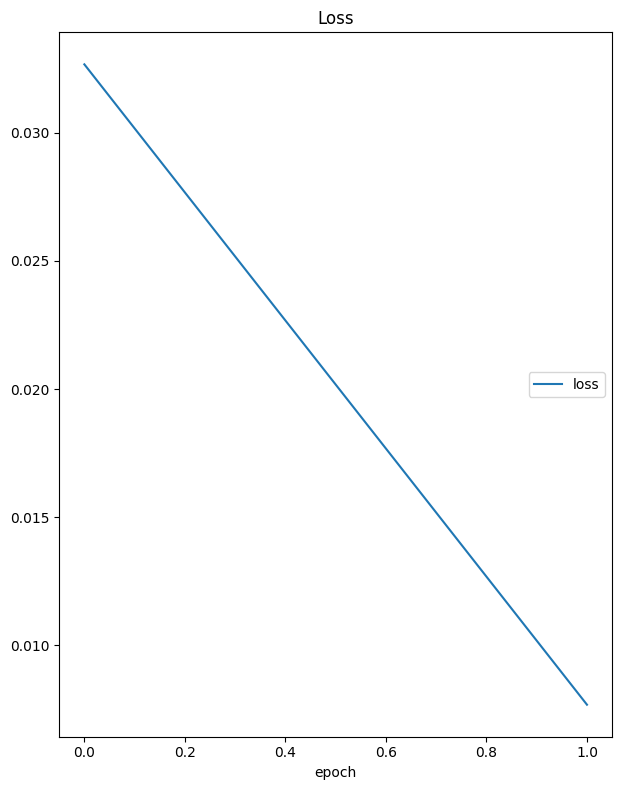

Loss
	loss             	 (min:    0.008, max:    0.033, cur:    0.008)
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 611ms/step - loss: 0.0100


[I 2024-08-02 09:36:43,353] Trial 2 finished with value: 0.007684319745749235 and parameters: {'TIME_SERIES_SIZE': 33, 'n_layers': 8, 'activation': 'tanh', 'n_units_l0': 382, 'n_units_l1': 174, 'n_units_l2': 122, 'n_units_l3': 12, 'n_units_l4': 377, 'n_units_l5': 141, 'n_units_l6': 35, 'n_units_l7': 94, 'learning_rate': 0.001613049473157793}. Best is trial 2 with value: 0.007684319745749235.


<built-in method keys of dict object at 0x000001F21A287100>
creating model
training model with 10 timesteps, 6 layers, relu activation, 0.0041089791468857184 learning rate
Epoch 1/2


: 

In [11]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

In [7]:
save_path = "optuna_results"
study_name = "new loader"

In [9]:

os.makedirs(save_path, exist_ok=True)
save_study = optuna.create_study(study_name=study_name, storage=f"sqlite:///{save_path}/{study_name}.db")
save_study.add_trials(study.trials)
study.trials_dataframe().to_csv(f"{save_path}/{study_name}.csv")
print(study.best_params)

NameError: name 'save_path' is not defined

In [8]:
loaded_study = optuna.load_study(study_name=study_name, storage=f"sqlite:///{save_path}/{study_name}.db")
print(loaded_study.best_params)

{'TIME_SERIES_SIZE': 5, 'n_layers': 1, 'activation': 'linear', 'n_units_l0': 43, 'learning_rate': 0.0001175406457187126}


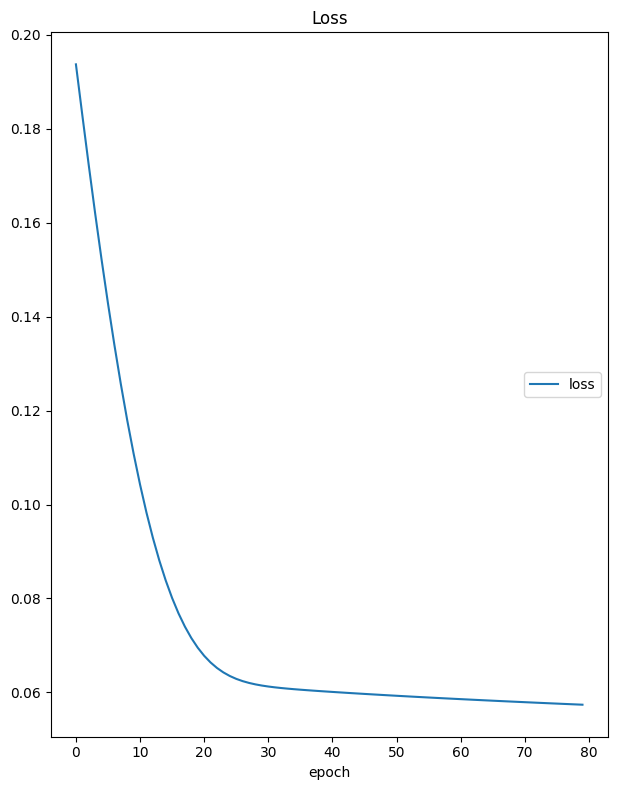

Loss
	loss             	 (min:    0.057, max:    0.194, cur:    0.057)
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0574


In [35]:
#train model with best params
SAMPLES = 1
VALIDATION_SPLIT = 0
EPOCHS = 80
BATCH_SIZE = 32
params = loaded_study.best_params
params = {'TIME_SERIES_SIZE': 1, 'n_layers': 2, 'activation': 'tanh', 'n_units_l0': 80, 'n_units_l1': 30, 'n_units_l2': 100, 'n_units_l3': 100, 'n_units_l4': 80, 'n_units_l5': 80, 'n_units_l6': 80, 'n_units_l7': 60, 'n_units_l8': 50, 'n_units_l9': 30, 'learning_rate': 0.1e-5}

#set tf precision to float 64
#Check default float precision
print("Default float precision:", tf.keras.backend.floatx())

#Change default float precision to float64
tf.keras.backend.set_floatx('float64')
print("Updated float precision:", tf.keras.backend.floatx())

TIME_SERIES_SIZE = params["TIME_SERIES_SIZE"]
train_input_data, train_gt_data = read_data(SAMPLES)
train_gt_data_normalized = normalize_data(train_gt_data, "gt")
train_input_data_normalized = normalize_data(train_input_data, "gnss")
train_input_data_padded, train_gt_data_padded = sort_data(train_input_data_normalized, train_gt_data_normalized, SAMPLES)
train_data, validation_data = batch_data(TIME_SERIES_SIZE, train_input_data_padded, train_gt_data_padded, VALIDATION_SPLIT, BATCH_SIZE)
del train_input_data, train_gt_data, train_input_data_normalized, train_gt_data_normalized, train_input_data_padded, train_gt_data_padded
    

n_layers = params["n_layers"]
activation = params["activation"]
model = Sequential()

model.add(Masking(mask_value=0, input_shape=(iter(train_data).next()[0].shape[1], iter(train_data).next()[0].shape[2])))
model.add(Dense(400, activation=activation)
model.add(Dense(300, activation=activation))
model.add(Dense(200, activation=activation))
model.add(Dense(100, activation=activation))
model.add(Dense(50, activation=activation))
model.add(Dense(2, activation="linear"))
# for i in range(n_layers-1):
#     model.add(LSTM(params[f"n_units_l{i}"] , activation=activation, return_sequences=True))
# model.add(LSTM(params[f"n_units_l{n_layers-1}"], activation=activation))
model.add(Dense(iter(train_data).next()[1].shape[1], activation="linear"))    

learning_rate = params["learning_rate"]

model.compile(optimizer=Adam(learning_rate), loss="MeanSquaredError")
#model.compile(optimizer="adam", loss="MeanSquaredError")
print(model.summary())

first = iter(train_data).next()
first_input = first[0]
first_gt = first[1]
print(first_gt[0][0].dtype)

history = model.fit(train_data, epochs=EPOCHS, validation_data=validation_data, callbacks=[PlotLossesKeras(), DecimeterError()], verbose=1)
#return validation score as indicator for the model quality
#print(history.history["val_loss"][-1])


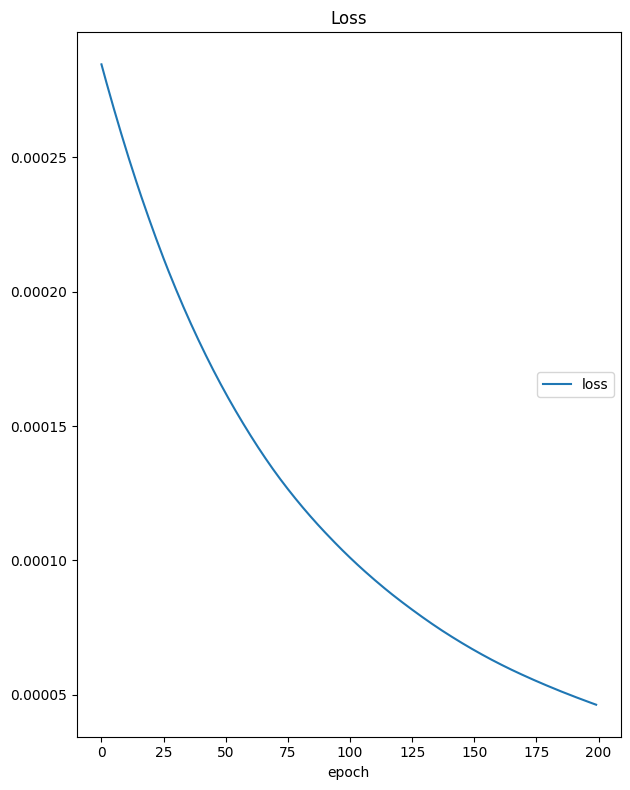

Loss
	loss             	 (min:    0.000, max:    0.000, cur:    0.000)
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 5.1354e-05


In [29]:
history = model.fit(train_data, epochs=200, validation_data=validation_data, callbacks=[PlotLossesKeras(), DecimeterError()], verbose=1)


In [38]:
# visualize trajectory on map
trajectory_index = 0

inp, outp = read_data(trajectory_index+1)
path_data = [[inp[trajectory_index]], [outp[trajectory_index]]]

gt_data_normalized = normalize_data(path_data[1], "gt")
gnss_data_normalized = normalize_data(path_data[0], "gnss")
print(model.input_shape)

#input_data,_  = sort_data(TIME_SERIES_SIZE, gnss_data_normalized, gt_data_normalized, 1,None,BATCH_SIZE, model.input_shape[2]-11)
gnss_data_padded, gt_data_padded = sort_data(gnss_data_normalized, gt_data_normalized, 1, model.input_shape[2]-11)
input_data,_ = batch_data(TIME_SERIES_SIZE, gnss_data_padded, gt_data_padded, 0, BATCH_SIZE)
# print(input_data.element_spec)
# for i, data in enumerate(input_data):
#     print(data[0].shape)
#     if i > 20:
#         break

# print(model.summary())
# for i, sample in enumerate(input_data):
#     for timeseries in sample[0]:
#         print(f"input: {timeseries.numpy()}")
#         print(timeseries.shape)
#         print(f"output: {model.predict(np.array([timeseries]))}")
#     break
              
prediction = model.predict(input_data)
prediction = np.array(unnormalize(prediction, "gt"))
print(prediction.shape)
gt = np.array([unnormalize(sample, "gt") for sample in gt_data_normalized], dtype=np.float32)
print(f"datatype gt: {gt.dtype}")

#predicted_path = prediction[:,0:3]
predicted_path = prediction[:,0,0:3]
gt_path = gt[0,:,0:3]


#plot it on a map


m = folium.Map(location=[predicted_path[0,0], predicted_path[0,1]], zoom_start=25, max_zoom=35)

for i in range(len(predicted_path)-1):
    folium.PolyLine([[predicted_path[i,0], predicted_path[i,1]], [predicted_path[i+1,0], predicted_path[i+1,1]]], color="blue").add_to(m)
    folium.PolyLine([[gt_path[i,0], gt_path[i,1]], [gt_path[i+1,0], gt_path[i+1,1]]], color="red").add_to(m)

folium.Marker([predicted_path[-1,0], predicted_path[-1,1]], popup=f"predicted: {predicted_path[-1,0]}, {predicted_path[-1,1]}", icon=folium.Icon(color="red")).add_to(m)
folium.Marker([gt_path[-1,0], gt_path[-1,1]], popup=f"gt: {gt_path[-1,0]}, {gt_path[-1,1]}", icon=folium.Icon(color="red")).add_to(m)

m.save("map.html")





read in 1 samples
normalizing gt data
normalizing gnss data
(None, 1, 348)
sample 1 sorted
reading imu data
read in 1 samples
normalizing IMU data
(1300, 12)
padding train data
inserting IMU data
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
unnormalizing gt data
(1298, 1, 2)
unnormalizing gt data
datatype gt: float32
